In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns
%matplotlib inline

import sklearn
from sklearn.metrics import accuracy_score
import xgboost as xgb

%load_ext watermark
%load_ext blackcellmagic

In [2]:
#loading data
df_train_y = pd.read_csv("../CS155_PROJECT1/Data/caltech-cs155-2020/train.csv", index_col=0, usecols = [0,27])
df_train = pd.read_csv("../CS155_PROJECT1/Data/caltech-cs155-2020/train.csv", index_col=0, usecols = lambda column : column not in["y"])
df_train_full= pd.read_csv("../CS155_PROJECT1/Data/caltech-cs155-2020/train.csv", index_col=0)
df_test = pd.read_csv("../CS155_PROJECT1/Data/caltech-cs155-2020/test.csv", index_col=0)

#splitting into training and validation sets 
X_train, X_validate, y_train, y_validate = sklearn.model_selection.train_test_split(df_train, df_train_y, test_size=0.3, shuffle = False)

In [3]:
#loading data into xgb format, deprecated in this version
dtrain = xgb.DMatrix(X_train, label = y_train)
dvalidate =xgb.DMatrix(X_validate, label = y_validate)
dtest = xgb.DMatrix(df_test)

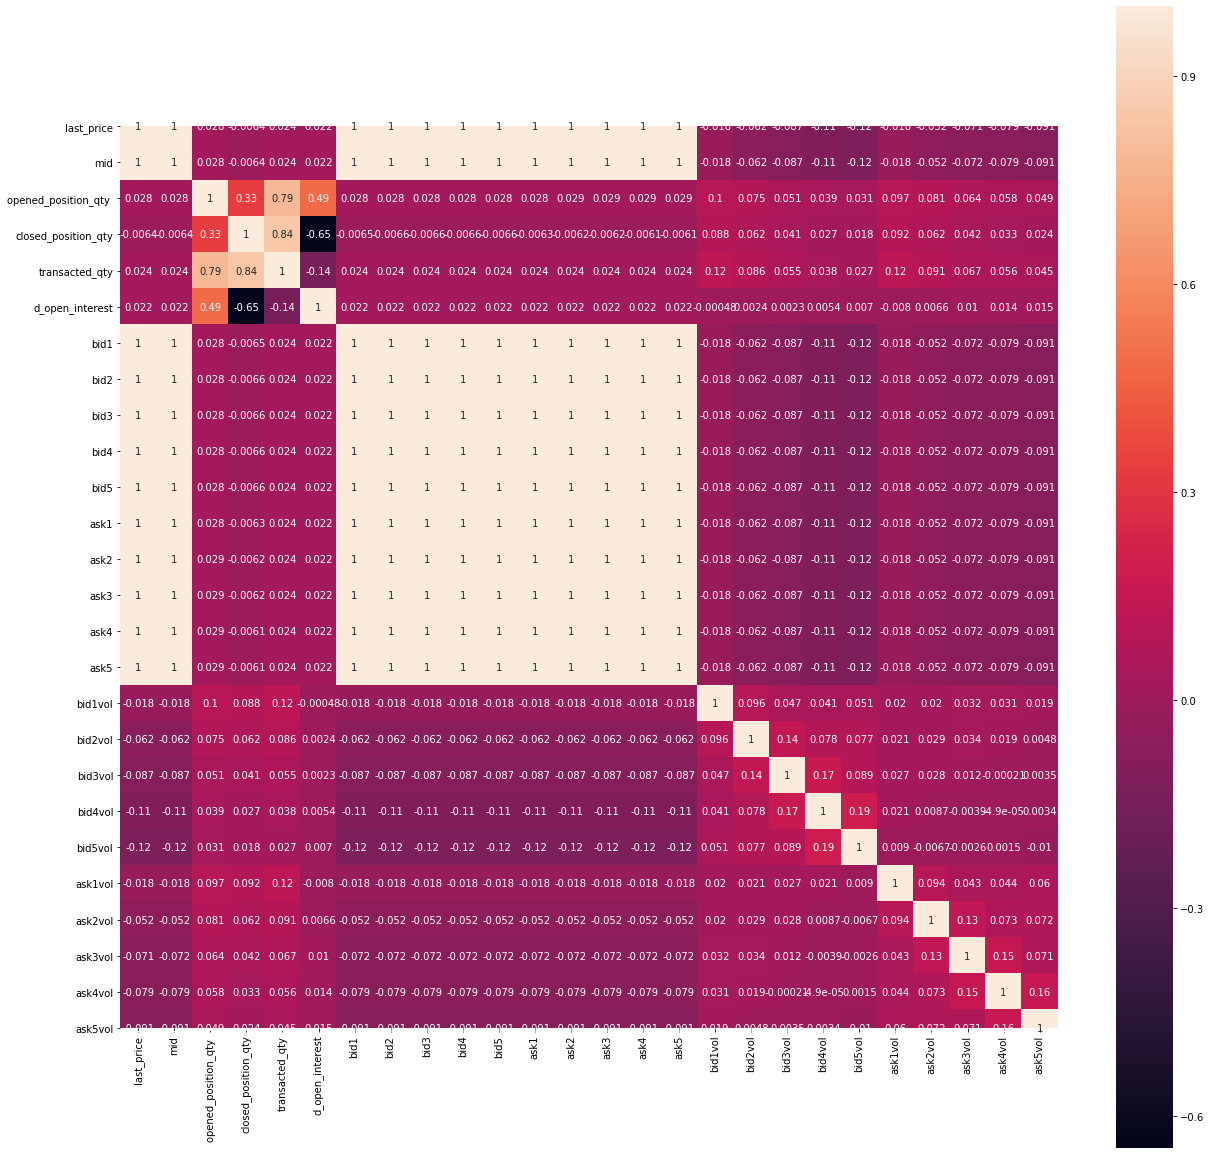

In [4]:
cor_mat= df_train[:].corr()
fig=plt.gcf()
fig.set_size_inches(21,21)
sns.heatmap(data=cor_mat, square=True, annot=True, cbar=True)
#plt.savefig('corr-matrix.png')

### Model parameter tuning

#### First, test how many estimators to use:

In [16]:
xgb1 = xgb.XGBClassifier(
    learning_rate =0.2,
    n_estimators=200,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    seed=28
)

eval_set = [(X_train, y_train), (X_validate, y_validate)]

In [17]:
xgb1.fit(X_train, y_train, eval_metric ='auc',eval_set=eval_set, early_stopping_rounds=5)

[0]	validation_0-auc:0.636056	validation_1-auc:0.625879
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.639059	validation_1-auc:0.628353
[2]	validation_0-auc:0.641594	validation_1-auc:0.630343
[3]	validation_0-auc:0.642227	validation_1-auc:0.630869
[4]	validation_0-auc:0.642476	validation_1-auc:0.631
[5]	validation_0-auc:0.643501	validation_1-auc:0.631798
[6]	validation_0-auc:0.643989	validation_1-auc:0.632323
[7]	validation_0-auc:0.644831	validation_1-auc:0.632777
[8]	validation_0-auc:0.645445	validation_1-auc:0.633378
[9]	validation_0-auc:0.6457	validation_1-auc:0.63335
[10]	validation_0-auc:0.6461	validation_1-auc:0.633697
[11]	validation_0-auc:0.646247	validation_1-auc:0.6334
[12]	validation_0-auc:0.646453	validation_1-auc:0.633428
[13]	validation_0-auc:0.646627	validation_1-auc:0.633315
[14]	validation_0-auc:0.647051	validation_1-auc:0.633408
[15]	vali

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=28,
              silent=None, subsample=0.8, verbosity=1)

#### To compare different parameter values, we will use 135 estimators. First, we will approximate them with 10 estimators for computational speed. 

##### Optimize max depth and min child weight simulataneously

In [9]:
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

gsearch1 = sklearn.model_selection.GridSearchCV(estimator = xgb.XGBClassifier(
    learning_rate =0.2,
    n_estimators=14,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    seed=28
),param_grid = param_test1, scoring='roc_auc',n_jobs=4, iid=False, cv=5)


gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

/Users/nicholassarai/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/nicholassarai/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicholassarai/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'max_depth': 3, 'min_child_weight': 1}, 0.641965337353781)

In [10]:
param_test2 = {
    'max_depth':range(2,3,4),
    'min_child_weight':range(1,2,3)
}

gsearch2 = sklearn.model_selection.GridSearchCV(estimator = xgb.XGBClassifier(
    learning_rate =0.2,
    n_estimators=10,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    seed=28
),param_grid = param_test2, scoring='roc_auc',n_jobs=4, iid=False, cv=5)


gsearch2.fit(X_train,y_train)
gsearch2.best_params_, gsearch2.best_score_

/Users/nicholassarai/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicholassarai/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'max_depth': 2, 'min_child_weight': 1}, 0.6384907273309703)

In [11]:
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = sklearn.model_selection.GridSearchCV(estimator = xgb.XGBClassifier(
    learning_rate =0.2,
    n_estimators=10,
    max_depth=2,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    seed=28
),param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch3.best_score_

/Users/nicholassarai/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/nicholassarai/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicholassarai/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'gamma': 0.0}, 0.6384907273309703)

In [23]:
xgb2 = xgb.XGBClassifier(
    learning_rate =0.2,
    n_estimators=150,
    max_depth=2,
    min_child_weight=1,
    gamma=0.0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    seed=28
)

eval_set = [(X_train, y_train), (X_validate, y_validate)]

In [24]:
xgb2.fit(X_train, y_train, eval_metric ='auc',eval_set=eval_set, early_stopping_rounds=5)

[0]	validation_0-auc:0.608942	validation_1-auc:0.600658
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.622567	validation_1-auc:0.612876
[2]	validation_0-auc:0.626931	validation_1-auc:0.616842
[3]	validation_0-auc:0.629076	validation_1-auc:0.619118
[4]	validation_0-auc:0.629454	validation_1-auc:0.619454
[5]	validation_0-auc:0.631827	validation_1-auc:0.621797
[6]	validation_0-auc:0.633146	validation_1-auc:0.622931
[7]	validation_0-auc:0.635628	validation_1-auc:0.625611
[8]	validation_0-auc:0.636883	validation_1-auc:0.62698
[9]	validation_0-auc:0.638249	validation_1-auc:0.628152
[10]	validation_0-auc:0.638726	validation_1-auc:0.628528
[11]	validation_0-auc:0.639325	validation_1-auc:0.629108
[12]	validation_0-auc:0.640153	validation_1-auc:0.629898
[13]	validation_0-auc:0.640457	validation_1-auc:0.63019
[14]	validation_0-auc:0.640815	validation_1-auc:0.630633
[

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.0,
              learning_rate=0.2, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=28,
              silent=None, subsample=0.8, verbosity=1)

In [25]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = sklearn.model_selection.GridSearchCV(estimator = xgb.XGBClassifier(
    learning_rate =0.2,
    n_estimators=10,
    max_depth=2,
    min_child_weight=1,
    gamma=0.0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    seed=28
),param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch4.fit(X_train,y_train)
gsearch4.best_params_, gsearch4.best_score_

/Users/nicholassarai/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/nicholassarai/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicholassarai/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'colsample_bytree': 0.8, 'subsample': 0.6}, 0.6389571140124816)

In [27]:
xgb3 = xgb.XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=2,
    min_child_weight=1,
    gamma=0.0,
    subsample=0.6,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    seed=28
)

eval_set = [(X_train, y_train), (X_validate, y_validate)]

In [28]:
xgb3.fit(X_train, y_train, eval_metric ='auc',eval_set=eval_set, early_stopping_rounds=10)

[0]	validation_0-auc:0.609272	validation_1-auc:0.600676
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.621907	validation_1-auc:0.612379
[2]	validation_0-auc:0.625179	validation_1-auc:0.61549
[3]	validation_0-auc:0.628408	validation_1-auc:0.618615
[4]	validation_0-auc:0.629743	validation_1-auc:0.619824
[5]	validation_0-auc:0.631132	validation_1-auc:0.621358
[6]	validation_0-auc:0.632301	validation_1-auc:0.622374
[7]	validation_0-auc:0.634798	validation_1-auc:0.625179
[8]	validation_0-auc:0.636191	validation_1-auc:0.626459
[9]	validation_0-auc:0.636309	validation_1-auc:0.626352
[10]	validation_0-auc:0.637218	validation_1-auc:0.627358
[11]	validation_0-auc:0.63735	validation_1-auc:0.627347
[12]	validation_0-auc:0.637063	validation_1-auc:0.627059
[13]	validation_0-auc:0.637183	validation_1-auc:0.627056
[14]	validation_0-auc:0.637687	validation_1-auc:0.627607


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.0,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=28,
              silent=None, subsample=0.6, verbosity=1)

In [29]:
#predict on validation set
ypred_xgb3 = xgb3.predict_proba(X_validate)[:,1]

In [30]:
#calculate AUC on validation set
roc = sklearn.metrics.roc_auc_score(y_validate, ypred_xgb3)
print("AUC: %.4f%% " % (roc * 100))

AUC: 63.4498% 


In [31]:
#predict on test set
predictions = xgb3.predict_proba(df_test)

# Kaggle needs the submission to have a certain format;
submission = pd.DataFrame({ 'id': df_test.index,
                            'Predicted': predictions[:,1]})

In [34]:
#is the format correct?
submission.head()

,id,Predicted
count,191859.000000,191859.000000
mean,688309.000000,0.405475
std,55385.066986,0.113856
min,592380.000000,0.119252
25%,640344.500000,0.315082
50%,688309.000000,0.411737
75%,736273.500000,0.488592
max,784238.000000,0.729045


In [33]:
submission.to_csv("submission2.csv", index=False)